# Holt's Linear Forecasting with Hyperparameter Tuning
### Using Holt's Linear with Hyperparameter tuning to forecast Jetrail traffic for next 7 months for investment purpose. 

* Holt's two-parameter model, also known as linear exponential smoothing, is a popular smoothing model for forecasting data with trend. Holt's model has three separate equations that work together to generate a final forecast. The method is also called double exponential smoothing or trend-enhanced exponential smoothing.
* In this notebook, we will sample data daily, forecast daily data and then transform back to hourly data.

## Import all required libraries

In [505]:
import pandas as pd
import numpy as np
from pandas import Series
from math import sqrt

# metrics
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm

# forecasting model
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

# for analysis
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 7

from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Load Jetrail traffic dataset

In [506]:
train_original=pd.read_csv('../input/jetrail-traffic-dataset/Train.csv')
test_original=pd.read_csv('../input/jetrail-traffic-dataset/Test.csv')

train_original.dropna(inplace=True)
test_original.dropna(inplace=True)
test_original.drop(test_original.tail(1).index, inplace=True)

train_df=train_original.copy()
test_df=test_original.copy()
test_df.sample(5)

,Unnamed: 0,ID,Datetime
2419,2419,20707,04-01-2015 19:00
58,58,18346,28-09-2014 10:00
3522,3522,21810,19-02-2015 18:00
4223,4223,22511,20-03-2015 23:00
1882,1882,20170,13-12-2014 10:00


## Feature engineering

In [507]:
train_original['Datetime']=pd.to_datetime(train_original.Datetime, format='%d-%m-%Y %H:%M')
test_original['Datetime']=pd.to_datetime(test_original.Datetime, format='%d-%m-%Y %H:%M')
train_df['Datetime']=pd.to_datetime(train_df.Datetime, format='%d-%m-%Y %H:%M')
test_df['Datetime']=pd.to_datetime(test_df.Datetime, format='%d-%m-%Y %H:%M')

# generate day, month, year feature
for i in (train_original, test_original, train_df, test_df):
    i['year']=i.Datetime.dt.year
    i['month']=i.Datetime.dt.month
    i['day']=i.Datetime.dt.day
    i['hour']=i.Datetime.dt.hour

In [508]:
# sampling for daily basis
train_df.index=train_df.Datetime
test_df.index=test_df.Datetime

## Helper Functions

In [509]:
def plot_result(train_data, valid_data, pred_data):
    plt.figure(figsize=(12,7))
    train_data.plot(label='Train')
    valid_data.plot(label='Valid')
    pred_data.plot(label='Prediction')
    _=plt.legend(loc='best')

In [510]:
# Change resample
def resample(data, sample_by):
    data_resample=data.resample(sample_by).mean()
    return data_resample

In [511]:
# train valid split
def train_valid_split(data, train_start_date='2012-08-25', train_end_date='2014-06-24', valid_start_date='2014-06-25', valid_end_date='2014-09-25'):
    train=data.loc[train_start_date:train_end_date]
    valid=data.loc[valid_start_date:valid_end_date]
    return (train, valid)

In [512]:
# rmse calculation
def rmse(valid, pred):
    # calculate mse
    rmse=mean_squared_error(valid, pred, squared=False)
    return rmse

In [513]:
# check for stationary of data with daily basis
df=resample(train_df, 'D')
dftest=adfuller(df.Count, autolag='AIC')
dfout=pd.Series(dftest[0:4], index=['Test statistics', 'p-value', '#Lags used', 'Number of observation used'])
for key, val in dftest[4].items():
    dfout['Critical value (%s)'%key]=val
print(dfout)
# p-value > 0.05 -> non-stationary data
# p-value < 0.05 -> stationary data

Test statistics                 2.986351
p-value                         1.000000
#Lags used                     20.000000
Number of observation used    741.000000
Critical value (1%)            -3.439206
Critical value (5%)            -2.865448
Critical value (10%)           -2.568851
dtype: float64


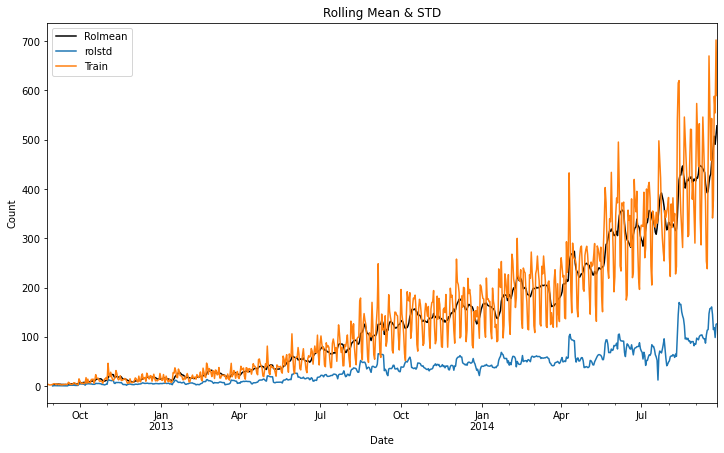

In [514]:
# check rolling mean and std
# resample data to daily basis
df=resample(train_df, 'D')
# determine rolling stats
rolmean=df.Count.rolling(window=7).mean() #for 7 days
rolstd=df.Count.rolling(window=7).std()
rolmean.dropna(inplace=True)
rolstd.dropna(inplace=True)

plt.figure(figsize=(12,7))
rolmean.plot(label='Rolmean', color='black')
rolstd.plot(label='rolstd')
df.Count.plot(label='Train')
_=plt.legend(loc='best')
plt.title('Rolling Mean & STD')
plt.xlabel('Date')
_=plt.ylabel('Count')

In [515]:
# helper function for grid CV search hyperparameter tuning
def grid_search(params, train_data, valid_data):
    best_rmse=1e10
    best_param=0
    for param1 in params['damped']:
        for param2 in params['exp']:
            for param3 in params['optim']:
                for param4 in params['smooth_level_grid']:
                    for param5 in params['smooth_slope_grid']:
                        for param6 in params['damping_slope_grid']:
                            for param7 in params['initial_level_grid']:
                                for param8 in params['initial_slope_grid']:
                                    fit1=Holt(train_data, damped=param1, exponential=param2).fit(
                                        optimized=param3,
                                        smoothing_level=param4, 
                                        smoothing_slope=param5,
                                        damping_slope=param6,
                                        initial_level=param7,
                                        initial_slope=param8
                                    )
                                    pred=fit1.forecast(len(valid_data))
                                    # check rmse
                                    pred=np.nan_to_num(pred, nan=0)
                                    # print(valid_data, pred)
                                    rmse_err=rmse(pred, valid_data)
                                    print('params: ',(param1, param2,param3, param4, param5, param6, param7, param8), 
                                          ' rmse: %.4f'%rmse_err)
                                    if rmse_err<best_rmse:
                                        best_rmse=rmse_err
                                        best_param=(param1, param2,param3, param4, param5, param6, param7, param8)
    print('Best param: ',best_param, ' rmse: %.4f'%best_rmse)
    return best_param

In [516]:
def holt_forecast(train_data, valid_data, params):
    fit1=Holt(np.asarray(train_data), damped=params[0], exponential=params[1]).fit(
        optimized=params[2],
        smoothing_level=params[3], 
        smoothing_slope=params[4],
        damping_slope=params[5],
        initial_level=params[6],
        initial_slope=params[7])
    pred=fit1.forecast(len(valid_data))
    pred=pd.Series(pred, index=valid_data.index)
    plot_result(train_data, valid_data, pred)
    return pred

In [517]:
# convert daily basis to hourly basis using hour traffic ratio
def convert_to_hourly(forecast, train_df_hourly, test_df_hourly, train_=1):
    train_origin=train_df_hourly.copy()
    test_origin=test_df_hourly.copy()
    # convert to hourly basis
    pred_df=pd.DataFrame(forecast, columns=['predict']).reset_index()
    pred_df['year']=pred_df.Datetime.dt.year
    pred_df['month']=pred_df.Datetime.dt.month
    pred_df['day']=pred_df.Datetime.dt.day

    if(train_==1):
        pred_df=pd.merge(pred_df, train_origin, on=('year', 'month', 'day'), how='left')
    else:
        pred_df=pd.merge(pred_df, test_origin, on=('year', 'month', 'day'), how='left')

    # count hour ratio
    train_origin['ratio']=train_origin.Count/train_origin.Count.sum()
    grp_ratio=train_origin.groupby('hour')['ratio'].sum().reset_index()

    pred_hour=pd.merge(pred_df, grp_ratio, on='hour', how='left')
    pred_hour=pd.DataFrame(pred_hour.predict*pred_hour.ratio*24, columns=['Count']).set_index(pred_hour.Datetime_y)
    return pred_hour.Count

## Hyperparameter tuning

In [518]:
# split train valid
train, valid=train_valid_split(train_df)

# resample by day
train_sample=resample(train, 'D')
valid_sample=resample(valid, 'D')

# grid search for Holt linear
PARAMS={
    'damped':[False],
    'exp':[False],
    'optim':[True],
    'smooth_level_grid':np.arange(0,1,0.35),
    'smooth_slope_grid':np.arange(0,1,0.2),
    'damping_slope_grid':[None],
    'initial_level_grid':[None],
    'initial_slope_grid':np.arange(0.9,1.5,0.2)#[1.2]
}
best_param=grid_search(PARAMS, train_sample.Count.values, valid_sample.Count.values)

params:  (False, False, True, 0.0, 0.0, None, None, 0.9)  rmse: 277.0183
params:  (False, False, True, 0.0, 0.0, None, None, 1.1)  rmse: 413.3895
params:  (False, False, True, 0.0, 0.0, None, None, 1.3000000000000003)  rmse: 553.2745
params:  (False, False, True, 0.0, 0.2, None, None, 0.9)  rmse: 277.0183
params:  (False, False, True, 0.0, 0.2, None, None, 1.1)  rmse: 413.3895
params:  (False, False, True, 0.0, 0.2, None, None, 1.3000000000000003)  rmse: 553.2745
params:  (False, False, True, 0.0, 0.4, None, None, 0.9)  rmse: 277.0183
params:  (False, False, True, 0.0, 0.4, None, None, 1.1)  rmse: 413.3895
params:  (False, False, True, 0.0, 0.4, None, None, 1.3000000000000003)  rmse: 553.2745
params:  (False, False, True, 0.0, 0.6000000000000001, None, None, 0.9)  rmse: 277.0183
params:  (False, False, True, 0.0, 0.6000000000000001, None, None, 1.1)  rmse: 413.3895
params:  (False, False, True, 0.0, 0.6000000000000001, None, None, 1.3000000000000003)  rmse: 553.2745
params:  (False, Fa

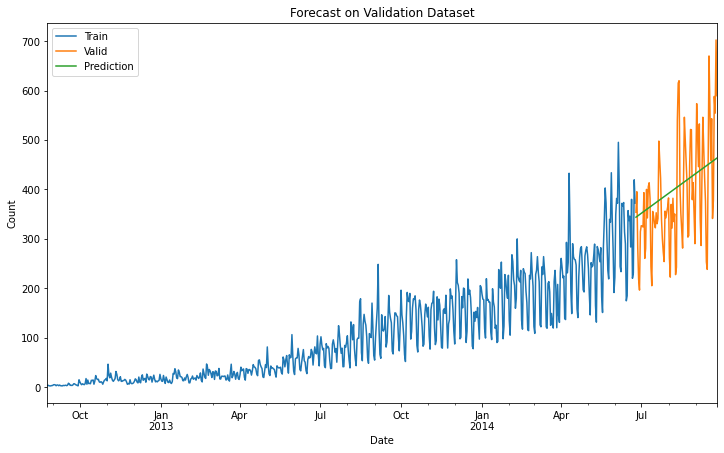

In [519]:
pred=holt_forecast(train_sample.Count, valid_sample.Count, best_param)
plt.title('Forecast on Validation Dataset')
plt.xlabel('Date')
_=plt.ylabel('Count')

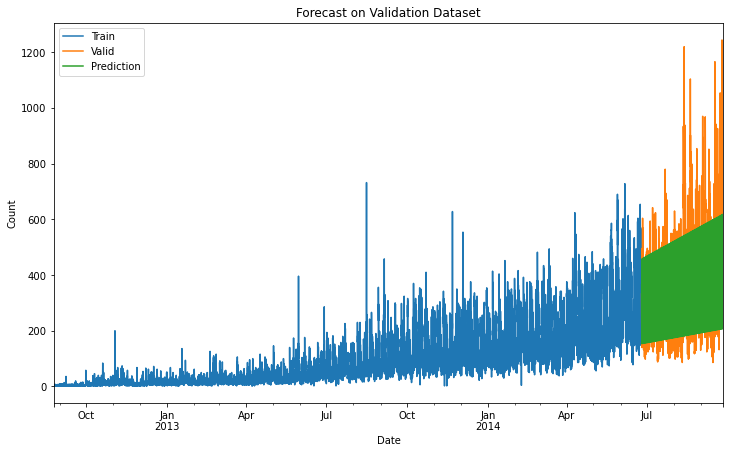

In [520]:
pred_hourly=convert_to_hourly(pred, train_df, test_df)
plot_result(train.Count, valid.Count, pred_hourly)
plt.title('Forecast on Validation Dataset')
plt.xlabel('Date')
_=plt.ylabel('Count')

## Test forecasting

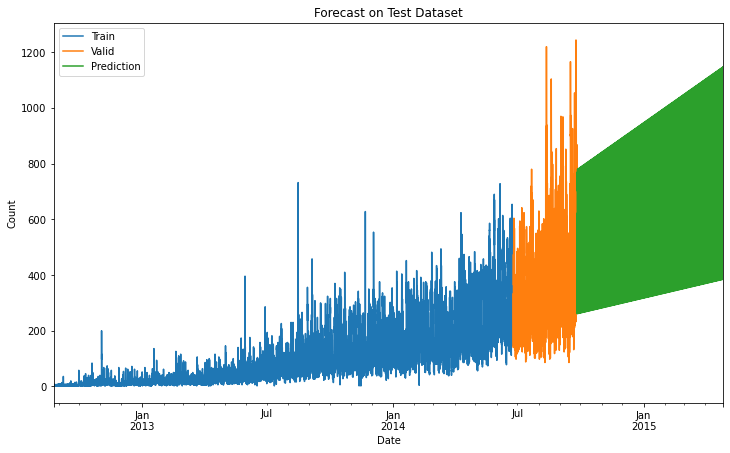

In [521]:
train_sample=resample(train_df, 'D')
test_sample=resample(test_df, 'D')

# fit1=Holt(np.asarray(train_sample.Count)).fit(smoothing_level=best_param[3], smoothing_slope=best_param[4])
fit1=Holt(np.asarray(train_sample.Count), damped=best_param[0], exponential=best_param[1]).fit(
        optimized=best_param[2],
        smoothing_level=best_param[3], 
        smoothing_slope=best_param[4],
        damping_slope=best_param[5],
        initial_level=best_param[6],
        initial_slope=best_param[7])
pred=fit1.forecast(len(test_sample))
pred=pd.Series(pred, index=test_sample.index)

pred_hourly=convert_to_hourly(pred, train_df, test_df, train_=0)
plot_result(train.Count, valid.Count, pred_hourly)
plt.title('Forecast on Test Dataset')
plt.xlabel('Date')
_=plt.ylabel('Count')

In [523]:
# forecasting result
pred_hourly.index=test_df.ID
pd.DataFrame(pred_hourly).sample(10)
# score 186.5 on AV Public LB

## Conclusion
* RMSE validation score: 98.2379
* RMSE test score: 186.5 still need improvement
* Daily forecasting with Holt's not fit enough with real values

Next, we will try to improve with Weekly or Monthly forecasting and do some feature engineering.

#### Thank you :D